# Machine learning experiment 2-2 -- SVM Classifier

In [1]:
# setup code

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

# Data Loading and Preprocessing

In [2]:
# Load the raw housing_scale data.
filename_train = '../dataset/a9a'
filename_test = '../dataset/a9a.t'
X_train, y_train = load_svmlight_file(filename_train, n_features = 123)
X_test, y_test = load_svmlight_file(filename_test, n_features = 123)
X_train, X_test = X_train.toarray(), X_test.toarray()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (32561, 123)
Train labels shape:  (32561,)
Test data shape:  (16281, 123)
Test labels shape:  (16281,)


In [3]:
# preprocessing: substract the mean of each feature
# first: compute the mean of the features of train data

_mean = np.mean(X_train, axis = 0)
# print(_mean)

In [4]:
# second: subtract the mean from train and test data
X_train -= _mean
X_test -= _mean

In [5]:
# third: append the bias dimension of ones
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_test.shape)

(32561, 124) (16281, 124)


# Helper Function

In [6]:
def compute_accuracy(y_pred, y_grondtrue):
    return np.mean(np.array(y_pred == y_grondtrue), dtype = np.float32)

# Optimizer

In [7]:
class GradientDescent(object):

    def __init__(self, learning_rate = 0.01):
        self.learning_rate = learning_rate
        
    def update(self, W, grad):
        return W - self.learning_rate * grad

In [8]:
class NAG(object):

    def __init__(self, learning_rate = 0.01, mu = 0.9):
        self.v = None
        self.learning_rate = learning_rate
        self.mu = mu
        
    def update(self, W, grad):
        if self.v is None:
            self.v = np.zeros(W.shape)
        v_prev = self.v
        self.v = self.mu * self.v + self.learning_rate * grad
        W -= self.mu * v_prev + (1 + self.mu) * self.v
        return W

In [9]:
class RMSProp(object):

    def __init__(self, learning_rate = 0.01, decay_rate = 0.9):
        self.cache = None
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
    
    def update(self, W, grad):
        if self.cache is None:
            self.cache = np.zeros(W.shape)
        self.cache = self.decay_rate * self.cache + (1 - self.decay_rate) * np.square(grad)
        W -= self.learning_rate * grad / (np.sqrt(self.cache) + 1e-5)
        return W

In [10]:
class AdaDelta(object):
    
    def __init__(self, decay_rate = 0.9):
        self.accumulate_grad = None
        self.accumulate_update = None
        self.decay_rate = decay_rate
    
    def update(self, W, grad):
        if self.accumulate_grad is None:
            self.accumulate_grad = np.zeros(W.shape)
            self.accumulate_update = np.zeros(W.shape)
        self.accumulate_grad = self.decay_rate * self.accumulate_grad \
                                + (1 - self.decay_rate) * np.square(grad)
        delta = - (np.sqrt(self.accumulate_update + 1e-5) / np.sqrt(self.accumulate_grad + 1e-5)) * grad
        W += delta
        self.accumulate_update = self.decay_rate * self.accumulate_update \
                                + (1 - self.decay_rate) * np.square(delta)
        return W

In [11]:
class Adam(object):

    def __init__(self, beta1=0.9, beta2=0.999, learning_rate=0.005, epsilon=1e-8):
        self.m = None
        self.v = None
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate = learning_rate
        self.epsilon = epsilon
    
    def update(self, W, grad, it):
        '''
        Inputs:
        - it: # iteration. use in the bias correction mechanism to warm up at the first few steps
        '''
        it += 1
        if self.m is None:
            self.m = np.zeros(W.shape)
            self.v = np.zeros(W.shape)
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(grad)
        mt = self.m / (1 - self.beta1 ** it)
        vt = self.v / (1 - self.beta2 ** it)
        W -= self.learning_rate * mt / (np.sqrt(vt) + self.epsilon)
        return W

# SVM Classifier

In [12]:
class SVMModel(object):
    
    def __init__(self):
        self.W = None
    
    def train(self, X, y, optimizer=GradientDescent, regularization_strength=1.0, num_iters=100, 
             batch_size=None, verbose=False):
        '''
        Train this svm classifier using optimizer provided.
        
        Inputs:
        - X: A numpy array of shape (N, D) containing training data;
             there are N training samples each of dimension D.
        - y: A numpy array of shape (N,) comtaining training labels.
        - optimizer: the algrithm used to train the model (update the para self.W).
        - regularization_strength: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing.
        - batch_size: (interger) number of training examples to use at each;
                      if not provided (batch_size == None), using normal GD (without stochastic)
        - verbose: (boolean) if true, print progress during optimization.
        '''
        num_train, dim = X.shape
        if self.W is None:
            self.W = 0.001 * np.random.random((dim, 1))
        
        loss_history = []
        for it in range(num_iters):
            X_batch, y_batch = None, None
            if batch_size is None:
                X_batch, y_batch = X, y
            else:
                sample_index = np.random.choice(num_train, batch_size, replace = True)
                X_batch, y_batch = X[sample_index], y[sample_index]
            
            loss, grad = self.loss(X_batch, y_batch, regularization_strength)
            loss_history.append(loss)
            
            # update the W use the optimizer
            self._update_parameter(optimizer, grad, it)
            
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss: %f' % (it, num_iters, loss))
        
        return loss_history
    
    def predict(self, X):
        '''
        Use the trained weights of the svm classifier to predict labels for data points.
        
        Inputs:
        - X: A numpy array of shape (N, D) containing data;
             there are N training samples each of dimension D.
        
        Returns:
        - y_pred: A numpy array of shape (N,) comtaining predicted labels for the data in X.
        '''
        
        _y = X.dot(self.W)
        y_pred = np.array(_y>0, dtype = np.float64)
        y_pred[y_pred == 0] = -1
        
        return y_pred.reshape(-1)
    
    def loss(self, X_batch, y_batch, regularization_strength=1):
        '''
        Compute the loss function and its gradient
        
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N data points;
                    each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - regularization_strength: (float) regularization strength
        
        Returns: A tuple containing:
        - loss as a single float
        - gradient of loss w.r.t. self.W (an array of the same shape as W)
        '''
 
        num_train, dim = X_batch.shape
        
        if self.W is None:
            self.W = 0.001 * np.random.random((dim, 1))
        
        _y = X_batch.dot(self.W) # (N, 1)
        loss = np.mean(np.maximum(0, 1 - y_batch.reshape(-1, 1) * _y)) + \
                regularization_strength * 0.5 * np.sum(np.square(self.W))
        
        coeff_mat = - X_batch * y_batch.reshape(-1, 1)
        coeff_mat[(1 - y_batch.reshape(-1, 1) * _y < 0).reshape(-1)] = 0
        
        grad = np.mean(coeff_mat, axis = 0).reshape(-1,1) + regularization_strength * self.W
        
        return loss, grad
    
    def _update_parameter(self, optimizer, grad, it):
        '''
        helper function: use optimizer to update parameter
        '''
        if isinstance(optimizer, GradientDescent):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, NAG):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, RMSProp):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, AdaDelta):
            self.W = optimizer.update(self.W, grad)
        elif isinstance(optimizer, Adam):
            self.W = optimizer.update(self.W, grad, it)

# Gradient Check

def eval_numerical_gradient(f, x, analytic_grad, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        
        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x)
        x[ix] = oldval - h
        neg = f(x)
        x[ix] = oldval

        grad_numerical = (pos - neg) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
        
        it.iternext()

W = np.zeros((X_train.shape[1], 1))

model = SVMModel()
loss, grad = model.loss_test(W, X_train, y_train, 1)
f = lambda w: model.loss_test(w, X_train, y_train, 1)[0]
grad_numerical = eval_numerical_gradient(f, W, grad)

# Contrast vanilla Gradient Descent with advanced optimized methods

In [13]:
reg = 0
num_iters = 300
batch_size = 1024

################  NAG  ################
nag = NAG(learning_rate=0.001, mu=0.9)
model_nag = SVMModel()
loss_history_nag = model_nag.train(X_train, y_train, nag, reg, num_iters, batch_size, False)

################  RMSprop  ################
rmsprop = RMSProp(learning_rate=0.005, decay_rate=0.9)
model_rmsprop = SVMModel()
loss_history_rmsprop = model_rmsprop.train(X_train, y_train, rmsprop, reg, num_iters, batch_size, False)

################  AdaDelta  ################
adadelta = AdaDelta(decay_rate=0.95)
model_adadelta = SVMModel()
loss_history_adadelta = model_adadelta.train(X_train, y_train, adadelta, reg, num_iters, batch_size, False)

################  Adam  ################
adam = Adam(beta1=0.9, beta2=0.999, learning_rate=0.1)
model_adam = SVMModel()
loss_history_adam = model_adam.train(X_train, y_train, adam, reg, num_iters, batch_size, False)


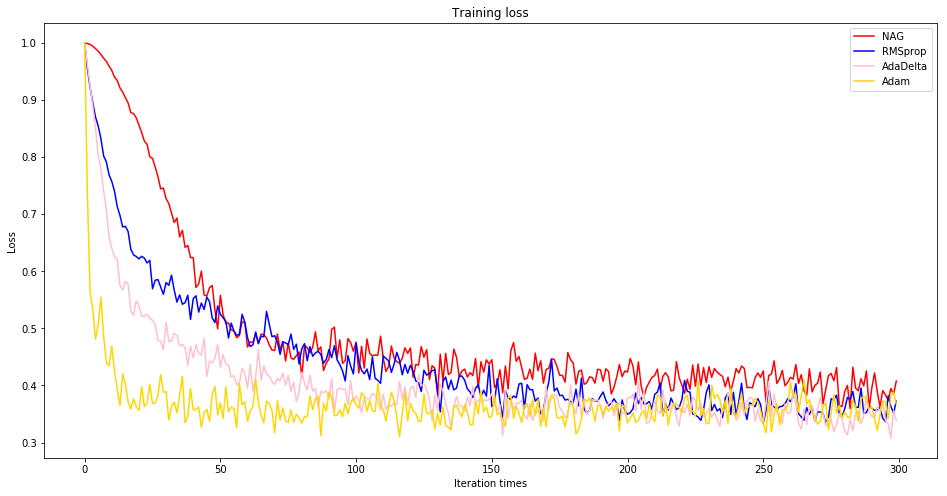

In [14]:
plt.title('Training loss')
plt.plot(loss_history_nag, 'r', label='NAG')
plt.plot(loss_history_rmsprop, 'b', label='RMSprop')
plt.plot(loss_history_adadelta, 'pink', label='AdaDelta')
plt.plot(loss_history_adam, 'gold', label='Adam')
plt.xlabel('Iteration times')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train Model with Adam

In [15]:
reg = 0
num_iters = 200
batch_size = 4096

adam = Adam(beta1=0.9, beta2=0.999, learning_rate=0.01)
model_adam = SVMModel()
loss_history = model_adam.train(X_train, y_train, adam, reg, num_iters, batch_size, True)
accuracy_train = compute_accuracy(model_adam.predict(X_train), y_train)
accuracy_test = compute_accuracy(model_adam.predict(X_test), y_test)

print('\n\ntrain accuarcy: %.5f' % accuracy_train)
print('test accuarcy: %.5f' % accuracy_test)

iteration 0 / 200: loss: 1.000432
iteration 10 / 200: loss: 0.715094
iteration 20 / 200: loss: 0.570039
iteration 30 / 200: loss: 0.526165
iteration 40 / 200: loss: 0.480906
iteration 50 / 200: loss: 0.462367
iteration 60 / 200: loss: 0.429042
iteration 70 / 200: loss: 0.414992
iteration 80 / 200: loss: 0.414023
iteration 90 / 200: loss: 0.400336
iteration 100 / 200: loss: 0.392110
iteration 110 / 200: loss: 0.377822
iteration 120 / 200: loss: 0.378336
iteration 130 / 200: loss: 0.384086
iteration 140 / 200: loss: 0.373661
iteration 150 / 200: loss: 0.385062
iteration 160 / 200: loss: 0.365955
iteration 170 / 200: loss: 0.363389
iteration 180 / 200: loss: 0.358209
iteration 190 / 200: loss: 0.358579


train accuarcy: 0.84755
test accuarcy: 0.84823


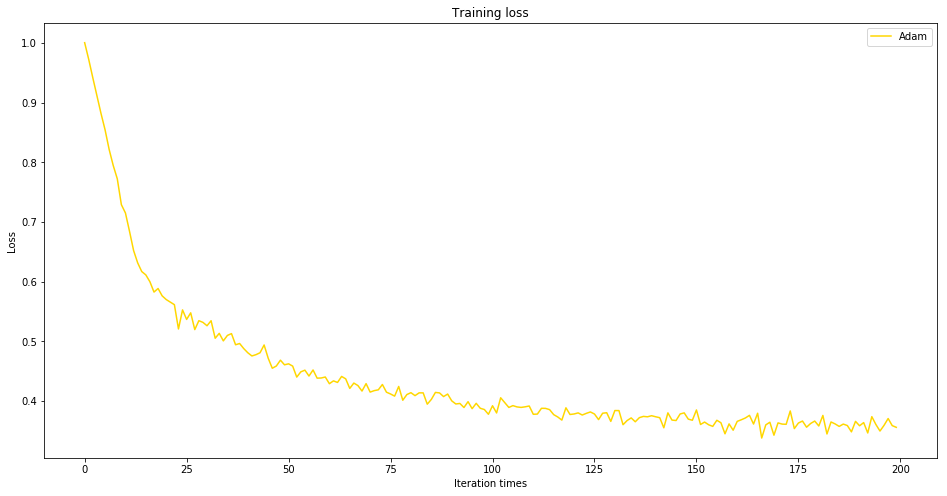

In [16]:
plt.title('Training loss')
plt.plot(loss_history, 'gold', label='Adam')
plt.xlabel('Iteration times')
plt.ylabel('Loss')
plt.legend()
plt.show()